In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import glob
from graphviz import Digraph
import networkx as nx
from nxpd import draw

# Recoding TEOTIL

This notebook attempts to emulate the calculations performed by TEOTIL for the RID project. The workflow is based on the description of TEOTIL in the [model manual](https://brage.bibsys.no/xmlui/handle/11250/214825), plus the configuration details used in the RID model files e.g. here:

K:\Avdeling\Vass\Teotil2\Norge_Regine\RID_tilforsler\2015\Run_totP_Norge_Regine.run

As a first step towards developing an improved model, I'd like to create a version that can read the existing TEOTIL input files and produce approximately the same output.

## 1. Read TEOTIL input files

The 2015 input files are copied here:

C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet\Recoding_TEOTIL\Linking_TEOTIL_Input_Files\Inputs_2015

which includes copies of the "static" files from here:

K:\Avdeling\Vass\Teotil2\Norge_Regine

Note that I've tidied some of the headings, so that each input file has just a single header row.

TEOTIL actually only reads a few columns from each of these files. I have copied the key information to the Excel file *simplified_inputs_2015.xlsx* to make the workflow easier to follow. The code below reads the original files and gets just the columns of interest.

**This code could be tidied up a lot!**

In [2]:
# Read data
data_fold = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
             r'\Recoding_TEOTIL\Linking_TEOTIL_Input_Files\Inputs_2015')

# List of files to process
search_path = os.path.join(data_fold, '*.txt')
file_list = glob.glob(search_path)

# Dict to store dfs
df_dict = {}

# Loop over data
for file_path in file_list:
    # Get name
    name = os.path.split(file_path)[1][:-4].lower()

    # Read file
    df = pd.read_csv(file_path, sep=';', comment='!', 
                     encoding='windows-1252')
    
    # Convert all headers to lower case
    #df.columns = [i.lower() for i in df.columns]
    
    # Add to dict
    df_dict[name] = df

In [3]:
# The data files currently require a lot of manual tidying, because they
# use different naming conventions and the column names aren't consistent.
# This should not be necessary if we create 'clean' inputs

# 1. Regine
df = df_dict['regine']
df = df[['Regine', ' RegineNed', 'AREAL_ENH_km2', 'STAT_NR', 
         'KOMNR', 'qsp_m3s', 'LOKALNAVN', 'VASSOMR', 'Fylke']]
df.columns = ['Regine', 'RegineNed', 'Areal_l', 'Stat', 'Komnr', 
              'Qsp', 'ID_Navn', 'Vassdrag', 'Fylke']
df.index = df['Regine']
del df['Regine']
df_dict['regine'] = df

# 2. Retention
df = df_dict['retensjon_regine']
df = df[['Regine', 'Retensjon_P', 'Retensjon_N']]
df.index = df['Regine']
del df['Regine']
df_dict['retensjon_regine'] = df

# 3. Land cover
df = df_dict['markslag_nijos_250']
df = df[['Regine', ' Jordbruk', ' Bebygd', 'Bre', ' Skog', 'Hav_250', 'Snaumark']]
df.columns = ['Regine', 'Adyrket_l', 'ABebygd_l', 'ABre_l', 'ASkog_l',
              'AHav_l', 'AFjell_l']
df.index = df['Regine']
del df['Regine']
df_dict['markslag_nijos_250'] = df

# 4. Lakes
df = df_dict['innsjo_areal_per_regine']
df = df[['Regine', 'A_0.25km2']]
df.columns = ['Regine', 'Ainnsjo_l']
df.index = df['Regine']
del df['Regine']
df_dict['innsjo_areal_per_regine'] = df

# 5. Background coeffs
df = df_dict['koeffisienter_bakgrunn']
df = df[['Regine', 'Cskog_mgl_P', 'Cfjell_mgl_P', 'Cinnsjo_kgkm2_P', 'Cvilla_kgkm2_P',
         'Cskog_mgl_N', 'Cfjell_mgl_N', 'Cinnsjo_kgkm2_N', 'Cvilla_kgkm2_N']]
df.columns = ['Regine', 'CskogP_mgl', 'CfjellP_mgl', 'CinnsjoP_kgkm2', 'CbebygdP_kgkm2',
              'CskogN_mgl', 'CfjellN_mgl', 'CinnsjoN_kgkm2', 'CbebygdN_kgkm2']
df.drop_duplicates(inplace=True)
df.index = df['Regine']
del df['Regine']
df_dict['koeffisienter_bakgrunn'] = df

# 6. Regine-FySone
df = df_dict['regine_fysone']
df = df[['Regine', 'Fylke_sone']]
df.drop_duplicates(inplace=True)
df.index = df['Regine']
del df['Regine']
df_dict['regine_fysone'] = df

# 7. Flow
df = df_dict['q_vassdrag']
df = df[['Vassdrag', 'Qsnitt', 'QAr']]
df.columns = ['Vassdrag', 'Qv_normal', 'Qv_ar']
df.index = df['Vassdrag']
df_dict['q_vassdrag'] = df

# 8. Aquaculture
df = df_dict['akvakultur']
df = df[['REGINE', 'Tot-P', 'Tot-N']]
df.columns = ['Regine', 'MakvaP_l', 'MakvaN_l']
df = df.groupby('Regine').sum().reset_index()
df.index = df['Regine']
del df['Regine']
df_dict['akvakultur'] = df

# 9. Renseanlegg
df = df_dict['renseanlegg']
df = df[['REGINE', 'Tot-P', 'Tot-N']]
df.columns = ['Regine', 'MtettP_l', 'MtettN_l']
df = df.groupby('Regine').sum().reset_index()
df.index = df['Regine']
del df['Regine']
df_dict['renseanlegg'] = df

# 10. Industry
df = df_dict['industri']
df = df[['REGINE', 'Tot-P', 'Tot-N']]
df.columns = ['Regine', 'MindP_l', 'MindN_l']
df = df.groupby('Regine').sum().reset_index()
df.index = df['Regine']
del df['Regine']
df_dict['industri'] = df

# 11. Spredt
df = df_dict['spredt']
df = df[['ID', 'Tot-P', 'Tot-N']]
df.columns = ['Komnr', 'MspredtP', 'MspredtN']
df_dict['spredt'] = df

# 12. Land use coeffs
df = df_dict['koeffisienter_jordbruk']
df = df[['Fylke_sone', 'Paker', 'Pdyrket_nat', 'Naker', 'Ndyrket_nat']]
df.columns = ['Fylke_sone', 'CakerP_kgkm2', 'Cdyrk_natP_kgkm2', 
              'CakerN_kgkm2', 'Cdyrk_natN_kgkm2']
df_dict['koeffisienter_jordbruk'] = df

C:\Data\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\pandas\util\decorators.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return func(*args, **kwargs)


In [4]:
# Join based on 'regine'
df_list = []

# DFs to join based on regine
reg_names = ['regine', 'retensjon_regine', 'markslag_nijos_250', 
             'innsjo_areal_per_regine', 'koeffisienter_bakgrunn',
             'regine_fysone', 'akvakultur', 'renseanlegg', 'industri']

# Add all to list
for name in reg_names:
    df_list.append(df_dict[name])

# Join
df = pd.concat(df_list, axis=1)

# Reset index
df.index.name = 'Regine'
df.reset_index(inplace=True)

# Join flow
df = pd.merge(df, df_dict['q_vassdrag'], 
              how='left', on='Vassdrag')

# Join spredt
#df = pd.merge(df, df_dict['spredt'], 
#              how='left', on='Komnr')

# Join LU coeffs
df = pd.merge(df, df_dict['koeffisienter_jordbruk'], 
              how='left', on='Fylke_sone')

# Drop rows without nertwork info
df.dropna(subset=['Regine', 'RegineNed'], how='any', inplace=True)

df.head()

,Regine,RegineNed,Areal_l,Stat,Komnr,Qsp,ID_Navn,Vassdrag,Fylke,Retensjon_P,...,MtettP_l,MtettN_l,MindP_l,MindN_l,Qv_normal,Qv_ar,CakerP_kgkm2,Cdyrk_natP_kgkm2,CakerN_kgkm2,Cdyrk_natN_kgkm2
0,001.,1_2,0.00,0,0.0,0.000,001.,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,001.10,001.,1.41,001.-1,101.0,0.014,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,37.5792,44.021303,120.921205,9.269811,2193.63055,409.999844
2,001.1A1,001.10,1.16,001.-1,101.0,0.014,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,37.5792,44.021303,120.921205,9.269811,2193.63055,409.999844
3,001.1A20,001.1A1,0.35,001.-1,101.0,0.010,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,37.5792,44.021303,120.921205,9.269811,2193.63055,409.999844
4,001.1A2A,001.1A20,17.40,001.-1,101.0,0.012,NaN,1.0,1.0,0.64,...,NaN,NaN,NaN,NaN,37.5792,44.021303,120.921205,9.269811,2193.63055,409.999844


In [5]:
# Field calculations

# 1a. Fill NaN in areas with zero
df['Adyrket_l'].fillna(value=0, inplace=True)
df['ABre_l'].fillna(value=0, inplace=True)
df['ASkog_l'].fillna(value=0, inplace=True)
df['AHav_l'].fillna(value=0, inplace=True)
df['AFjell_l'].fillna(value=0, inplace=True)
df['Ainnsjo_l'].fillna(value=0, inplace=True)
df['ABebygd_l'].fillna(value=0, inplace=True)

# 1b. Subtract marine area from land
df['Areal_l'] = df['Areal_l'] - df['AHav_l']
df.loc[df['Areal_l'] < 0, 'Areal_l'] = 0
df['Areal_l'].fillna(value=0, inplace=True)

# 2. Adjust 'mountain' area s.t. totals make sense
df['AFjell_l'] = (df['Areal_l'] - df['ASkog_l'] - df['Adyrket_l'] - 
                  df['Ainnsjo_l'] - df['ABebygd_l']) 
df.loc[df['AFjell_l'] < 0, 'AFjell_l'] = 0

# 3. Compare annual flow to long term reference values
df['Qkorr'] = df['Qv_ar'] / df['Qv_normal']
df['Qkorr'].fillna(value=1, inplace=True)

# 4. Update Qsp
df['Qsp'] =  df['Qsp'] * df['Qkorr']

# 5. Calculate Q_l
df['Q_l'] = df['Areal_l'] * df['Qsp']

# 5b. Fill NaN in point sources with 0
df['MakvaP_l'].fillna(value=0, inplace=True)
df['MakvaN_l'].fillna(value=0, inplace=True)
df['MtettP_l'].fillna(value=0, inplace=True)
df['MtettN_l'].fillna(value=0, inplace=True)
df['MindP_l'].fillna(value=0, inplace=True)
df['MindN_l'].fillna(value=0, inplace=True)

# 6. Get total land area and area of cultivated land in each regine
# and aggregate to kommune level
kom_ag = df[['Komnr', 'Areal_l', 'Adyrket_l']]
kom_ag = kom_ag.groupby('Komnr').sum()
kom_ag.reset_index(inplace=True)
kom_ag.columns = ['Komnr', 'Areal_Kom', 'Adyrket_Kom']

# 6b. Join to 'spredt' df
kom_ag = pd.merge(kom_ag, df_dict['spredt'],
                  how='left', on='Komnr')

# 6c. Join back to main df
df = pd.merge(df, kom_ag,
              how='left', on='Komnr')

# 6d. Distribute 'spredt' according to area ratios. If cultivated land exists
# in kommune, distribute spredt over regine according to ratio of
# (cultivated land regine) / (cultivated land kommune). Otherwise, use ratios
# of overall areas
# P
df['Mspredt_Kom_P_Dyrk'] = df['MspredtP'] * df['Adyrket_l'] / df['Adyrket_Kom']
df['Mspredt_Kom_P_Are'] = df['MspredtP'] * df['Areal_l'] / df['Areal_Kom']
df['MspredtP_l'] = np.where(df['Adyrket_Kom'] > 0, df['Mspredt_Kom_P_Dyrk'], 
                            df['Mspredt_Kom_P_Are'])

# N
df['Mspredt_Kom_N_Dyrk'] = df['MspredtN'] * df['Adyrket_l'] / df['Adyrket_Kom']
df['Mspredt_Kom_N_Are'] = df['MspredtN'] * df['Areal_l'] / df['Areal_Kom']
df['MspredtN_l'] = np.where(df['Adyrket_Kom'] > 0, df['Mspredt_Kom_N_Dyrk'], 
                            df['Mspredt_Kom_N_Are'])

# 7. Inputs from people
df['MbefolknP_l'] = df['MspredtP_l'] + df['MtettP_l']
df['MbefolknN_l'] = df['MspredtN_l'] + df['MtettN_l']

# 8. Anthropogenic inputs
df['MantropogP_l'] = df['MbefolknP_l'] + df['MindP_l'] + df['MakvaP_l']
df['MantropogN_l'] = df['MbefolknN_l'] + df['MindN_l'] + df['MakvaN_l']

# 9. Transmission
df['Trans_P'] = 1 - df['Retensjon_P']
df['Trans_N'] = 1 - df['Retensjon_N']

In [6]:
out_csv = r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet\Recoding_TEOTIL\Linking_TEOTIL_Input_Files\test.csv'
df.to_csv(out_csv, encoding='utf-8')

In [7]:
# Build graph (no weights or properties for now)
g = nx.DiGraph()

# Add nodes
for idx, row in df.iterrows():
    nd = row['Regine']
    g.add_node(nd, data=row.to_dict())
    
# Add edges
for idx, row in df.iterrows():
    fr_nd = row['Regine']
    to_nd = row['RegineNed']
    g.add_edge(fr_nd, to_nd)

In [8]:
# Set downstream node with default values
nd = nx.topological_sort(g, reverse=True)[1]
data = g.node[nd]['data']
data['Trans_P'] = 1
data['Trans_N'] = 1

# Work up network filling-in missing properties
for nd in nx.topological_sort(g, reverse=True)[2:]:
    # Get node data
    data = g.node[nd]['data']
    
    # Get node downstream
    suc = g.successors(nd)[0]   
    
    if np.isnan(data['CakerP_kgkm2']):
        data['CakerP_kgkm2'] = g.node[suc]['data']['CakerP_kgkm2']
        
    if np.isnan(data['CakerN_kgkm2']):
        data['CakerN_kgkm2'] = g.node[suc]['data']['CakerN_kgkm2']

    if np.isnan(data['Cdyrk_natP_kgkm2']):
        data['Cdyrk_natP_kgkm2'] = g.node[suc]['data']['Cdyrk_natP_kgkm2']
        
    if np.isnan(data['Cdyrk_natN_kgkm2']):
        data['Cdyrk_natN_kgkm2'] = g.node[suc]['data']['Cdyrk_natN_kgkm2']
        
    if np.isnan(data['CfjellP_mgl']):
        data['CfjellP_mgl'] = g.node[suc]['data']['CfjellP_mgl']
        
    if np.isnan(data['CfjellN_mgl']):
        data['CfjellN_mgl'] = g.node[suc]['data']['CfjellN_mgl']
        
    if np.isnan(data['CinnsjoP_kgkm2']):
        data['CinnsjoP_kgkm2'] = g.node[suc]['data']['CinnsjoP_kgkm2']
        
    if np.isnan(data['CinnsjoN_kgkm2']):
        data['CinnsjoN_kgkm2'] = g.node[suc]['data']['CinnsjoN_kgkm2'] 

    if np.isnan(data['CskogP_mgl']):
        data['CskogP_mgl'] = g.node[suc]['data']['CskogP_mgl']
        
    if np.isnan(data['CskogN_mgl']):
        data['CskogN_mgl'] = g.node[suc]['data']['CskogN_mgl'] 
        
    if np.isnan(data['Trans_P']):
        data['Trans_P'] = g.node[suc]['data']['Trans_P']
        
    if np.isnan(data['Trans_N']):
        data['Trans_N'] = g.node[suc]['data']['Trans_N'] 

In [9]:
# Catchment-level calculations
for nd in nx.topological_sort(g, reverse=True)[1:]:
    # Get data
    data = g.node[nd]['data']

    data['Mdyrk_natP_l'] = data['Adyrket_l']*data['Cdyrk_natP_kgkm2']*0.001
    data['Mdyrk_natN_l'] = data['Adyrket_l']*data['Cdyrk_natN_kgkm2']*0.001
    
    data['MjordbrP_l'] = (data['Adyrket_l']*data['CakerP_kgkm2']*0.001) - data['Mdyrk_natP_l']
    data['MjordbrN_l'] = (data['Adyrket_l']*data['CakerN_kgkm2']*0.001) - data['Mdyrk_natN_l']

    data['MskogP_l'] = (data['ASkog_l']*data['CskogP_mgl']*data['Qsp']*0.0864*365) + data['Mdyrk_natP_l']
    data['MskogN_l'] = (data['ASkog_l']*data['CskogN_mgl']*data['Qsp']*0.0864*365) + data['Mdyrk_natN_l']

    data['MinnsjoP_l'] = data['Ainnsjo_l']*data['CinnsjoP_kgkm2']*0.001
    data['MinnsjoN_l'] = data['Ainnsjo_l']*data['CinnsjoN_kgkm2']*0.001

    data['MbebygdP_l'] = data['ABebygd_l']*data['CbebygdP_kgkm2']*0.001
    data['MbebygdN_l'] = data['ABebygd_l']*data['CbebygdN_kgkm2']*0.001
    
    data['MfjellP_l'] = data['AFjell_l']*data['CfjellP_mgl']*data['Qsp']*0.0864*365
    data['MfjellN_l'] = data['AFjell_l']*data['CfjellN_mgl']*data['Qsp']*0.0864*365   
    
    data['MbefolkningP_l'] = data['MbefolknP_l'] + data['MbebygdP_l']
    data['MbefolkningN_l'] = data['MbefolknN_l'] + data['MbebygdN_l']

    data['MnaturP_l'] = data['MfjellP_l'] + data['MskogP_l'] + data['MinnsjoP_l']
    data['MnaturN_l'] = data['MfjellN_l'] + data['MskogN_l'] + data['MinnsjoN_l']

    data['MantropogP_l'] = data['MbefolkningP_l'] + data['MindP_l'] + data['MakvaP_l'] + data['MjordbrP_l']
    data['MantropogN_l'] = data['MbefolkningN_l'] + data['MindN_l'] + data['MakvaN_l'] + data['MjordbrN_l']

    data['MsumP_l'] = data['MantropogP_l'] + data['MnaturP_l']
    data['MsumN_l'] = data['MantropogN_l'] + data['MnaturN_l']

In [10]:
def accumulate_loads(g):
    """ Core function for TEOTIL-like network accumulation over a
        hydrological network.
    
    Args
        g Pre-built NetworkX graph. Must be a directed tree/forest
          and each nodes must have properties 'li' (internal load)
          and 'wt' (transmission factor)
          
    Returns
        Graph. g is modifed by adding the property 'Oi' to each node.
        This is the total amount of nutrient flowing out of the node.  
    """
    import networkx as nx
    
    # Check directed tree
    assert nx.is_tree(g), 'g is not a valid tree.'
    assert nx.is_directed_acyclic_graph(g), 'g is not a valid DAG.'   
    
    # Process nodes in topo order from headwaters down
    for nd in nx.topological_sort(g)[:-1]:
        # Get catchments directly upstream
        preds = g.predecessors(nd)
        
        if len(preds) > 0:
            # Accumulate total input from upstream
            in_p = 0
            in_n = 0
            for pred in preds:
                in_p += g.node[pred]['p_out']
                in_n += g.node[pred]['n_out']

            # Calculate output. Oi = Li + ti*Ii
            g.node[nd]['p_out'] = g.node[nd]['data']['MsumP_l'] + (g.node[nd]['data']['Trans_P']*in_p)
            g.node[nd]['n_out'] = g.node[nd]['data']['MsumN_l'] + (g.node[nd]['data']['Trans_N']*in_n)

        else:
            # No upstream inputs. Oi = ti * Li
            p_out = g.node[nd]['data']['MsumP_l'] * g.node[nd]['data']['Trans_P'] 
            n_out = g.node[nd]['data']['MsumN_l'] * g.node[nd]['data']['Trans_N'] 
            
            if np.isnan(p_out):
                p_out = 0
                
            if np.isnan(n_out):
                n_out = 0
            
            g.node[nd]['p_out'] = p_out
            g.node[nd]['n_out'] = n_out
    
    return g

In [11]:
# Run model
g = accumulate_loads(g)

# Compare results to Excel
res_p = []
res_n = []
tran_p = []
for nd in df['Regine']:    
    res_p.append(g.node[nd]['p_out'])
    res_n.append(g.node[nd]['n_out'])
    tran_p.append(g.node[nd]['data']['Trans_P'])
    
df['p_out'] = res_p
df['n_out'] = res_n
df['p_trans'] = tran_p

df = df[['Regine', 'p_out', 'n_out', 'p_trans']]

df.head(10)

,Regine,p_out,n_out,p_trans
0,001.,NaN,NaN,1.00
1,001.10,18.760325,629.890886,1.00
2,001.1A1,1.971322,185.491158,1.00
3,001.1A20,1.968322,185.192178,1.00
4,001.1A2A,0.370186,19.914311,0.36
5,001.1A2B,0.195331,13.636675,0.36
6,001.1A3,1.597489,165.213992,0.86
7,001.1A40,1.538472,162.549622,0.86
8,001.1A4A,0.194130,15.225581,0.52
9,001.1A4B,0.073675,6.246718,0.52


In [12]:
out_csv = r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet\Recoding_TEOTIL\Linking_TEOTIL_Input_Files\test2.csv'
df.to_csv(out_csv, encoding='utf-8')

In [16]:
print g.node['001.10']['p_out']
print g.node['001.10']['n_out']

18.7603250926
629.890885649


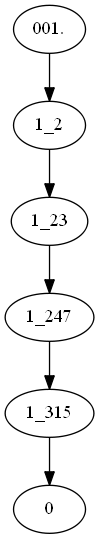

In [14]:
draw(nx.dfs_tree(g, '001.'), show='ipynb')

In [15]:
for nd in nx.topological_sort(nx.dfs_tree(g, '001.'), reverse=True)[1:]:
    print g.node[nd]['data']['Trans_P']


1
1
1
1
1
